# Testing PYMC v4

- https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html
- Setting cores=1 in bambi helped me avoid the pickling fortran error

<br>

***

<br>

## Connections & Imports

In [7]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
import bambi as bmb

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.0.0


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

<br>

***

<br>

In [4]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))
data.head()

,x,y
0,0.000000,0.819940
1,0.005025,0.929210
2,0.010050,1.557529
3,0.015075,0.985873
4,0.020101,1.020914


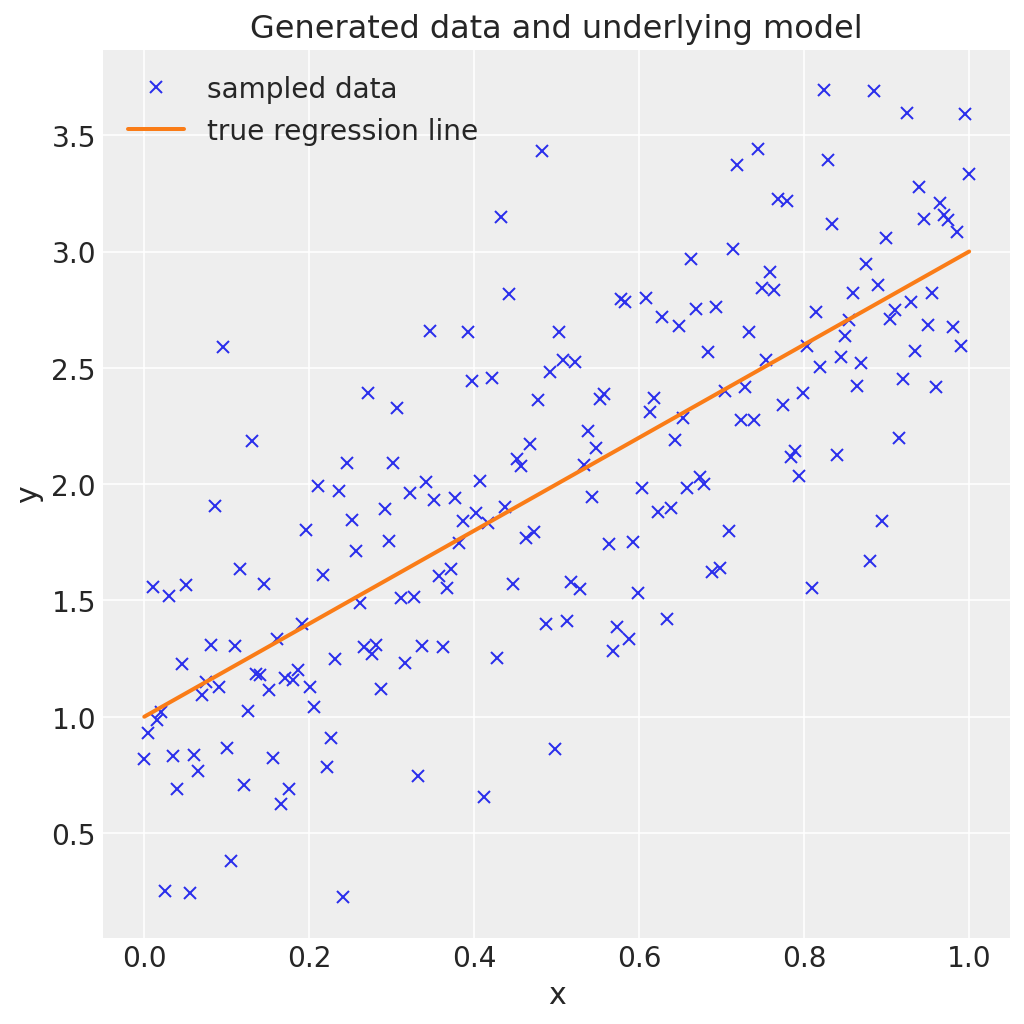

In [5]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [6]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8878, but should be close to 0.8. Try to increase the number of tuning steps.


# Bambi

In [12]:
model = bmb.Model("y~x",data)
idata = model.fit(draws=3000,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, x, y_sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 6 seconds.


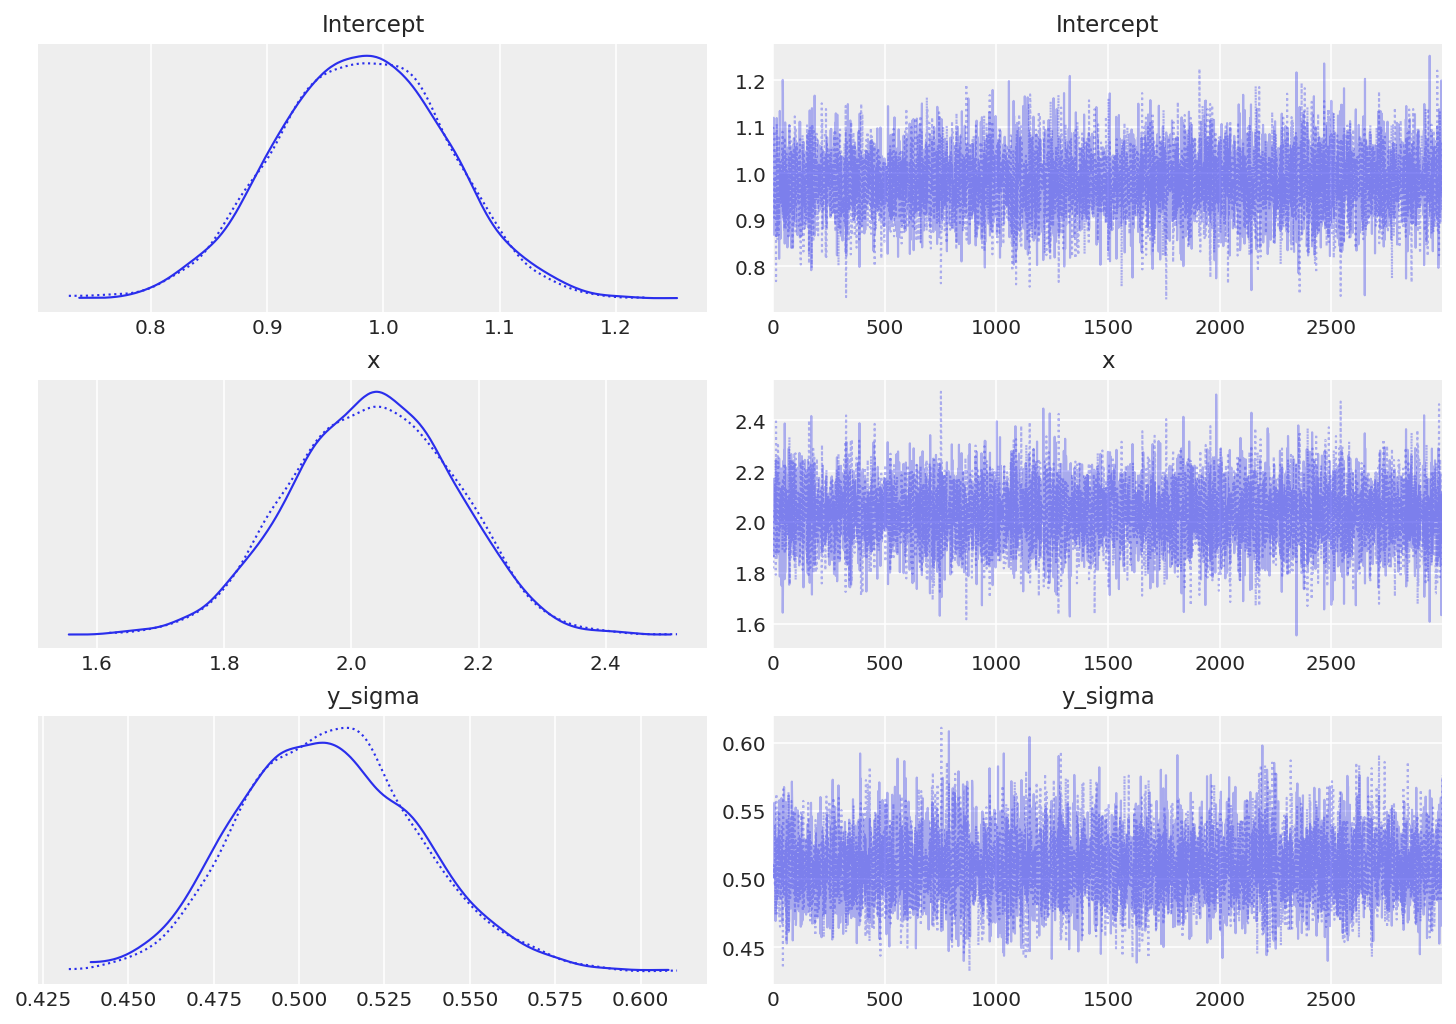

In [13]:
az.plot_trace(idata, figsize=(10, 7));

In [15]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"] * xr.DataArray(x)

C:\Users\wallj\anaconda3\envs\pymc4\lib\site-packages\arviz\plots\lmplot.py:209: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)
C:\Users\wallj\anaconda3\envs\pymc4\lib\site-packages\numpy\lib\shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


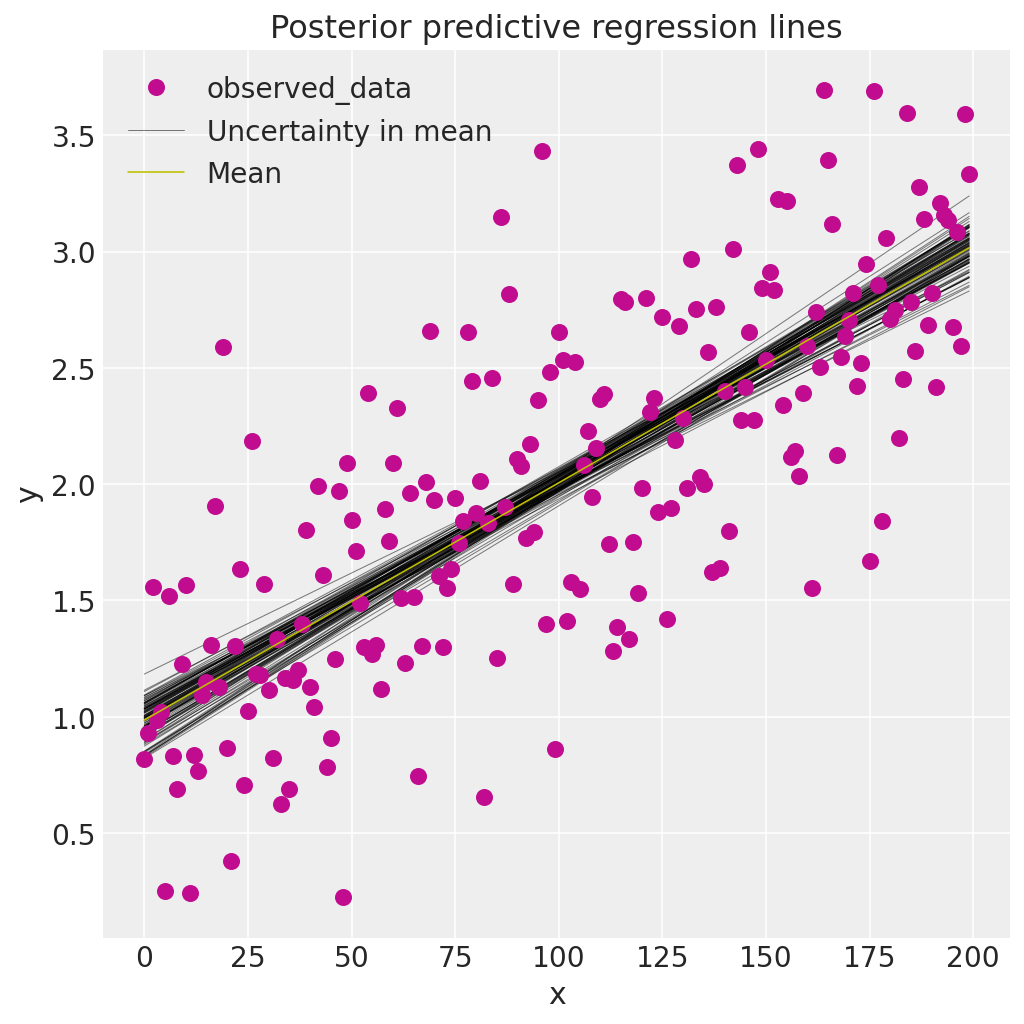

In [16]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=idata, y="y", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x");

In [19]:
%load_ext watermark

%watermark -n -u -v -iv -w -p aesara,aeppl

Last updated: Sat Oct 15 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

aesara: 2.6.6
aeppl : 0.0.31

arviz     : 0.12.1
numpy     : 1.21.6
bambi     : 0.9.0
pandas    : 1.4.3
matplotlib: 3.5.2
xarray    : 2022.3.0
pymc      : 4.0.0

Watermark: 2.3.1

